## Import packages

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Defining Transforms

In [13]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),      # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # reverse 50% of images
    transforms.Resize(224),             # resize shortest side to 224 pixels
    transforms.CenterCrop(224),         # crop longest side to 224 pixels at centre
    transforms.ToTensor(),
    transforms.Normalize([0.482, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.482, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## Prepare train and test sets, loaders

We will be using the in-built torchvision dataset tool called ImageFolder

In [14]:
root = './CATS_DOGS' # ran on local machine

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


## Display a batch of images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [1 0 1 0 0 1 0 1 0 0]
Class: DOG CAT DOG CAT CAT DOG CAT DOG CAT CAT


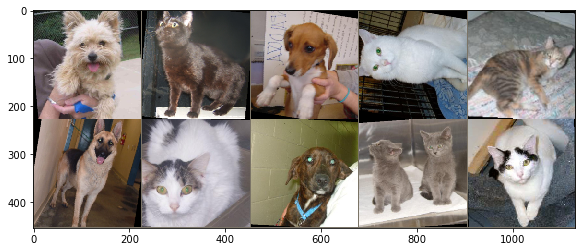

In [15]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## Define the model

Binary Classification
2 output channels

In [16]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

## Instantiate the model, define loss and optimization functions

In [17]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

### trainable parameters

In [18]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [19]:
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     168
       2
________
 5610222


# Train model

In [20]:
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

Training images available: 18743
Testing images available:  6251


In [21]:
import time
start_time = time.time()

epochs = 3

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_data)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/18743]  loss: 0.69065756  accuracy:  55.300%
epoch:  0  batch:  400 [  4000/18743]  loss: 0.66105974  accuracy:  58.325%
epoch:  0  batch:  600 [  6000/18743]  loss: 0.56951386  accuracy:  61.167%
epoch:  0  batch:  800 [  8000/18743]  loss: 0.56875110  accuracy:  62.900%
epoch:  0  batch: 1000 [ 10000/18743]  loss: 0.46232930  accuracy:  64.460%
epoch:  0  batch: 1200 [ 12000/18743]  loss: 0.72243857  accuracy:  65.325%
epoch:  0  batch: 1400 [ 14000/18743]  loss: 0.52955782  accuracy:  66.229%
epoch:  0  batch: 1600 [ 16000/18743]  loss: 0.58696371  accuracy:  66.925%
epoch:  0  batch: 1800 [ 18000/18743]  loss: 0.59096986  accuracy:  67.628%
epoch:  1  batch:  200 [  2000/18743]  loss: 0.37283617  accuracy:  72.450%
epoch:  1  batch:  400 [  4000/18743]  loss: 0.80271703  accuracy:  73.450%
epoch:  1  batch:  600 [  6000/18743]  loss: 0.68540382  accuracy:  73.517%
epoch:  1  batch:  800 [  8000/18743]  loss: 0.45897061  accuracy:  73.950%
epoch:  1  b

In [22]:
torch.save(CNNmodel.state_dict(), 'CatsAndDogsCNNModel.pt')

## Evaluation model performance 

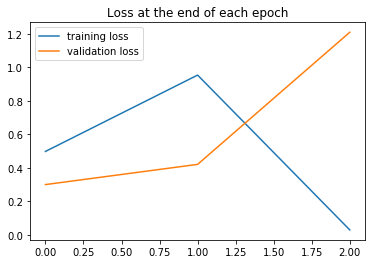

In [23]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

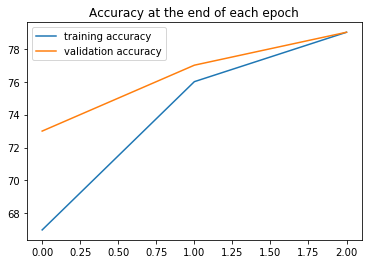

In [24]:
plt.plot([t/187 for t in train_correct], label='training accuracy')
plt.plot([t/62 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [25]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/6251:.3f}%')

[tensor(4574), tensor(4826), tensor(4929)]
Test accuracy: 78.851%
